In [1]:
import numpy as np
import pandas as pd

import astropy.units as u
import astropy.constants as c
import datetime

In [2]:
"MATPLOTLIB"
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm
import matplotlib.lines as lines

mpl.rcParams['font.family'] = 'Latin Modern Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

In [3]:
def Gain(D,freq):
    lam=c.c/(freq)
    A=np.pi*(D/2)**2
    e=1
    G=4*np.pi*e*A/lam**2 # calculate gain (Eq. A)
    return G.cgs

def power(tx,rx,df,rtdb,dl,sig=0.023*u.km**2,tau=(2*u.min).cgs): # from literature
    nametx=rtdb.Name[rtdb.Code==tx].iloc[0] # TX name from code
    namerx=rtdb.Name[rtdb.Code==rx].iloc[0] # RX name from code
    rtx=(df[nametx].to_numpy())*c.R_earth # distance to TX
    rrx=(df[namerx].to_numpy())*c.R_earth # distance to RX
    Dtx=rtdb.Diameter[rtdb.Code==tx].iloc[0]*u.m # TX diameter
    Drx=rtdb.Diameter[rtdb.Code==rx].iloc[0]*u.m # RX diameter
    Tsys=rtdb.Tsys[rtdb.Code==rx].iloc[0]*u.K # system temperature (RX)
    freq=rtdb.Frequency[rtdb.Code==tx].iloc[0]*1e6*u.Hz # transmission freq TX
    Ptx=rtdb.Power[rtdb.Code==tx].iloc[0]*1e3*u.W # transmission power TX
    Gtx=Gain(Dtx,freq) # TX gain
    Grx=Gain(Drx,freq) # RX gain
    Prx=(Ptx*Gtx*Grx*(c.c/(freq))**2*sig/((4*np.pi)**3*rtx**2*rrx**2)).si # calculate Prx (Eq. B)
    PrxdB=10*np.log10((Prx/u.mW).si.value)  #return Prx in dBm
    Pratio=(Prx/Ptx).si  #return TX/RX power ratio

    time=pd.to_datetime(dl.date)
    dt=(time.iloc[1]-time.iloc[0]).total_seconds()*u.s # time increment in dl
    lon=(dl.lonR.to_numpy())*u.deg.to(u.rad) # sub-radar longitude to radians
    lat=(dl.latR.to_numpy())*u.deg.to(u.rad) # sub-radar latitude to radians
    x=np.sin(lat)*np.cos(lon) # unit vector coord x
    y=np.sin(lat)*np.sin(lon) # unit vector coord y
    z=np.cos(lat) # unit vector coord z
    pointing=np.vstack((x,y,z)).T # unit vector of subradar pointing
    dtheta=np.arccos((pointing[1:]*pointing[:-1]).sum(axis=1)) # change in angle from moment to moment
    omega=dtheta/dt # angular frequency
    period=2*np.pi/omega # return rotation period
    rotfreq=1/period # rotation frequency
    phi=lat[1:] # subradar latitude
    bw=4*np.pi*np.cos(phi)*370*u.m/((c.c/freq)*period) # Doppler bandwidth (Eq. C)
    Nrms=(Tsys*c.k_B*np.sqrt(bw/tau)) # rms noise power (Eq. D)
    SNR=(Prx[1:]/Nrms).si # return signal-to-noise ratio 
    return PrxdB, Pratio, SNR, omega, nametx,namerx

In [4]:
df=pd.read_csv("../Data/observatory_distances_indexes.csv")
rtdb=pd.read_csv('../AllRadiotelescopes.csv')
dl=pd.read_csv('../Data/subradar_points.csv')
elevations = pd.read_csv("../Data/elevations.csv")

ephemeris = pd.read_csv("../ephemeris2.csv")
ephemeris['hours'] = 24*(ephemeris['datetime_jd']-ephemeris['datetime_jd'][0])
MIN = ephemeris['delta (Rt)'].argmin()

In [5]:
print([i for i in rtdb.Code])

['CDS', 'PRK', 'MDS', 'LOV', 'EFE', 'AVN', 'GOL', 'GBT', 'VLA', 'ARE', 'FAS', 'ECD', 'USU']


In [6]:
pairs = [
    ('CDS','PRK'),
    ('MDS','LOV'),
    ('MDS','AVN'),
    ('MDS','EFE'),
    ('GOL','GBT'),
    ('GOL','VLA'),
    ('ECD','FAS'),
    ('USU','FAS'),
]


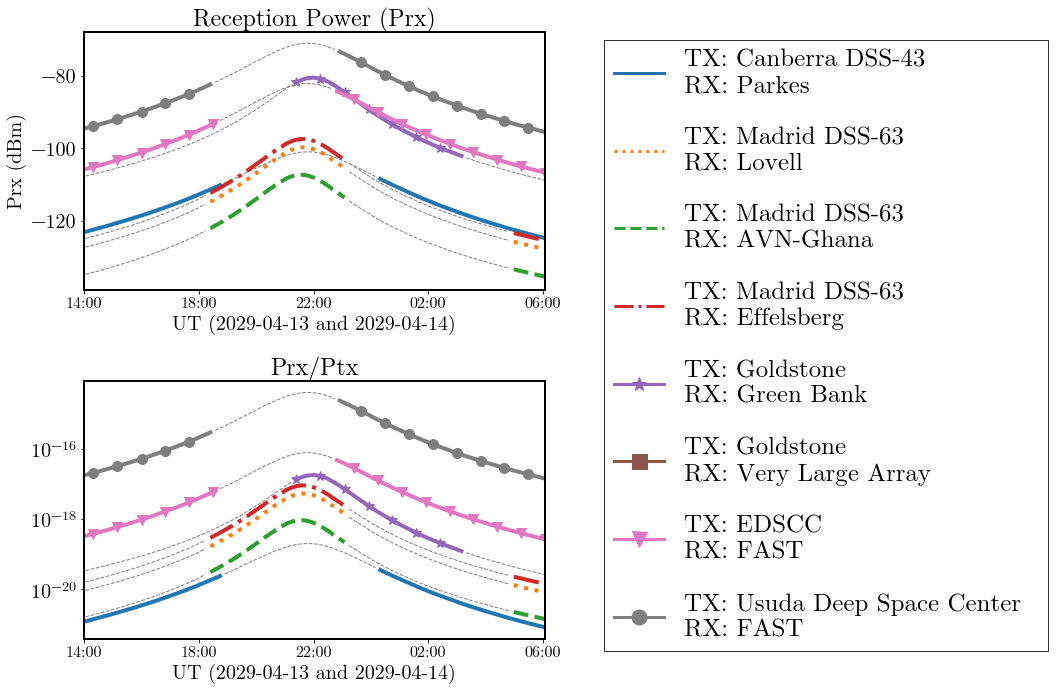

In [30]:
def x_axis(ax,i):
    ax.grid()
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),48)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][i] for i in xticks])

    if i != 10:
        ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)
        ax.set_xlabel("UT (2029-04-13 and 2029-04-14)",size=20)
    else:
        ax.set_xticklabels([])

    # if i == 3:
    #     ax.legend(fontsize=15)

def chop(Ys, cond):
    """
    Removes the parts of an array which correspond to non visible zones
    """
    pm = np.array([a*b for a,b in zip(elevations[tx],elevations[tx][1:])])
    nanwhere = np.where(pm < 0)
    
    Y = Ys
    Y[nanwhere] = np.nan
    Y = Y[cond]
    return Y
    

def all_power_plots(axes,n,PrxdB, Pratio, SNR, nametx,namerx,df,tx,rx):
    title='TX: {} \nRX: {}'.format(nametx,namerx)

    savefigs = False
    styles = ['-',':','--','-.','*-','s-','v-','o-']

    cond = elevations[tx] > 0
    times = ephemeris['hours'][cond]
    timesnt = ephemeris['hours'][~cond]

    Y = chop(PrxdB,cond)
    Ynt = chop(PrxdB,~cond)
    
    i = 0
    ax = axes[i]
    # dBm plot
    ax.plot(times,Y,styles[n],lw=4,markevery=10,ms=10)
    ax.plot(timesnt,Ynt,'--',lw=1,color='gray')
    ax.set_title("Reception Power (Prx)")
    ax.set_ylabel("Prx (dBm)")
    x_axis(ax,i)    

    Y = chop(Pratio,cond)
    Ynt = chop(Pratio,~cond)

    i += 1
    ax = axes[i]
    # SNR plot
    ax.semilogy(ephemeris['hours'][1:],SNR,styles[n],lw=3,markevery=10,ms=10)
    # ax.semilogy(ephemeris['hours'][1:],SNR,styles[n],lw=3,markevery=10,ms=10)
    ax.set_title("SNR")
    x_axis(ax,i)


    i += 1
    ax = axes[i]
    # Power ratio plot
    ax.semilogy(times,Y,styles[n],lw=4,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt,'--',lw=1,color='gray')
    ax.set_title("Prx/Ptx")
    x_axis(ax,i)

    Y = chop(SNR,cond[1:])
    Ynt = chop(SNR,~cond[1:])

    i += 1
    ax = axes[i]
    # rotation period plot
    ax.plot([],[],styles[n],lw=3,markevery=10,ms=15,label=title)
    # ax.set_ylabel("Angular frequency (deg/hour)")
    # ax.legend(fontsize=15)
    x_axis(ax,i)

fig, axes = plt.subplots(2,2,figsize=(15,10))

# for ax in axes.flat:
#     ax.set_prop_cycle(plt.cycler('color', plt.cm.nipy_spectral(np.linspace(0.1,0.9,5)**2)))
# fig.suptitle("Reception (rx) and Transmission (tx) Radar Power")

n = 0
for tx, rx in pairs:
    PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
    all_power_plots(axes.flat, n, PrxdB, Pratio, SNR, nametx, namerx, df, tx, rx)
    n += 1
    ax = axes.flat[-1]
handles, labels = axes.flat[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", fontsize=25, labelspacing=1.2, fancybox=False, edgecolor=(0,0,0))
fig.delaxes(axes.flat[-1])
fig.delaxes(axes.flat[-3])
fig.tight_layout()

# name = "../Figures/fig6_radio"
# plt.savefig(name+".pdf",bbox_inches='tight')
# plt.savefig(name+".png",bbox_inches='tight')

In [17]:
Brozović M.  and  Benner L. A. M. and  Naidu S. P. and  Busch M. W.  and Giorgini J. D. and  Taylor P. A. and  Rivera-Valentin E. G. and  Virkki A. K. and  Venditti F. C. F. and  Marshall S. E. and  Nolan M. C. and  Howell E. S. 

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False])